In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import datetime

DATA_FOLDER = './Data/'

In [2]:
train = pd.read_csv(DATA_FOLDER+'train.csv')
train.tail()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
4357331,6224518,1652603,47575,0,5,196.4,2,0,4,28,...,1,2721.0,0,24.56,0,0,3070.00,3,1475,0.8929
4357332,6224519,1653346,47592,2,2,358.1,4,3,2,7,...,0,0.0,0,0.00,0,0,2820.00,6,1484,0.7241
4357333,6224520,1657176,47679,0,3,559.0,4,1,3,8,...,0,0.0,0,0.00,1,0,400.60,2,1500,0.4483
4357334,6224521,1658403,47707,0,0,100.0,0,0,0,89,...,0,0.0,0,0.00,1,0,68.82,1,1502,0.1429
4357335,6224522,1658560,47710,0,2,126.3,1,1,0,24,...,0,0.0,0,0.00,0,0,2079.00,4,1517,0.8077


In [9]:
def formatGame(row):
    game = train[(train.matchId == row)]
    team = game.groupby(['Id','matchId','groupId','winPlacePerc'])['boosts','assists','kills','heals','DBNOs','damageDealt','headshotKills','rideDistance','walkDistance','weaponsAcquired'].sum().reset_index()
    team = team.set_index('Id')
    team = team.drop('groupId', axis=1)
    team = team.drop('matchId', axis=1)
    team['isWinner'] = team.winPlacePerc.map( lambda x: True if x == 1 else False)
    return team;

In [10]:
soloGames = train.query('numGroups>80')
soloID = soloGames.matchId.unique()
solo = formatGame(soloID[0])
for ID in tqdm(soloID):
    currentTeam = formatGame(ID)
    solo = solo.append(currentTeam)

100%|██████████| 5730/5730 [05:31<00:00, 17.28it/s]


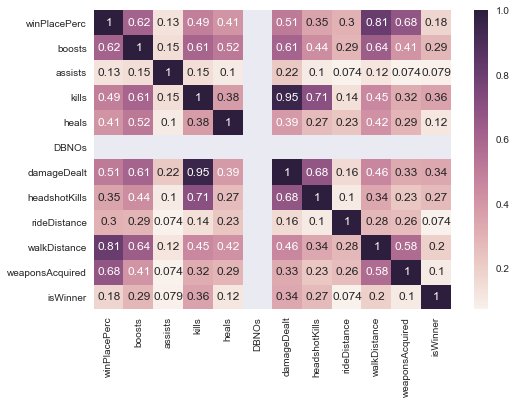

In [11]:
# plot the heatmap
corr = solo.corr()
ax = sns.heatmap(corr, annot=True)
plt.show()

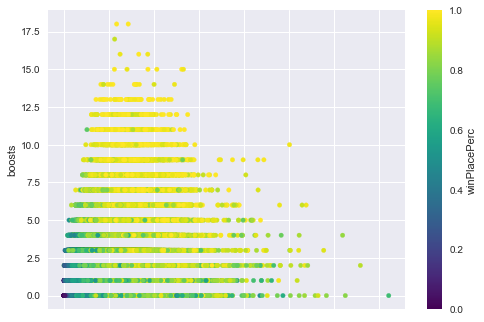

In [12]:
solo.plot.scatter(x='walkDistance',y='boosts',c='winPlacePerc',colormap='viridis')
plt.show()

## Silly linear regression

In [41]:
def MAE(y,x,w):
    N = len(x.index) 
    errors = np.empty(N, dtype=np.double)
    errors = y['winPlacePerc'] - x.dot(w)
    return np.mean(np.abs(errors))

In [42]:
def compute_gradient(y, tx, w):
    """Compute the gradient."""
    err = y - tx.dot(w)
    grad = -tx.T.dot(err) / len(err)
    return grad, err

In [43]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # compute loss, gradient
        grad, err = compute_gradient(y, tx, w)
        loss = np.mean(np.abs(err))
        # gradient w by descent update
        w = w - gamma * grad
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

In [44]:
x = teams[['boosts','walkDistance']]
y = teams[['winPlacePerc']]

In [45]:
# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = gradient_descent(y['winPlacePerc'], x, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=0.4483515509219354, w0=0.48364051869722546, w1=476.51718105206623
Gradient Descent(1/49): loss=473222.3138359608, w0=-605905.1454734381, w1=-649321224.7943362
Gradient Descent(2/49): loss=644832064697.565, w0=825630999759.5563, w1=884791455500592.4
Gradient Descent(3/49): loss=8.786743437465226e+17, w0=-1.1250383109140782e+18, w1=-1.2056527491064846e+21
Gradient Descent(4/49): loss=1.1973173243495611e+24, w0=1.5330228654121156e+24, w1=1.6428713708651444e+27
Gradient Descent(5/49): loss=1.631513182773855e+30, w0=-2.088959178614017e+30, w1=-2.238643210666239e+33
Gradient Descent(6/49): loss=2.2231660825678622e+36, w0=2.846500563279375e+36, w1=3.0504661007166695e+39
Gradient Descent(7/49): loss=3.029376337785427e+42, w0=-3.878757201050568e+42, w1=-4.156688920898752e+45
Gradient Descent(8/49): loss=4.127951153939112e+48, w0=5.285351992823424e+48, w1=5.664073034957889e+51
Gradient Descent(9/49): loss=5.624913787292592e+54, w0=-7.202035146844535e+54, w1=-7.718095

In [37]:
wStar = gradient_ws[1]
wStar

boosts            0.517716
walkDistance    494.381485
dtype: float64